In [2]:
# Importing required libraries

# Library for data cleaning and data manipulation
import pandas as pd
import numpy as np

# Library for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster

# Library for normality test
import scipy.stats as stats

# Library for text analysis
import re
from collections import Counter
import string

# Other libraries
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("Airbnb Listings Bangkok_clean.csv")

### **4. Listing Description and Keyword Analysis**

The Listing Description and Keyword Analysis examines how the language and content of listing descriptions impact pricing and occupancy across different neighbourhoods. The analysis categorizes listings based on whether the description is in English or another language and identifies the most frequently occurring keywords.

By analyzing the relationship between specific keywords and listing performance, it becomes evident which terms are associated with higher pricing and more reviews. This analysis provides actionable insights for optimizing listing descriptions to attract more guests and improve occupancy rates. In neighbourhoods where competition is high, leveraging the right keywords and language can significantly enhance a listing’s appeal and profitability.

#### **4.1. Impact on Keyword Analysis**

In [4]:
# Extract the listing descriptions
df["description"] = df["name"].fillna("") + " " + df["neighbourhood"].fillna("")

# Define a list of specific keywords/amenities to search for in descriptions
keywords = ["wifi", "pool", "breakfast", "view", "airport", "kitchen", "parking", "security", "gym"]

# Create columns to count the occurrence of each keyword in the description
for keyword in keywords:
    df[f"has_{keyword}"] = df["description"].apply(lambda x: bool(re.search(keyword, x, re.IGNORECASE)))

# Create a summary DataFrame to store the results of keyword analysis
keyword_summary = pd.DataFrame(index=keywords, columns=["avg_price_with", "avg_price_without", "avg_reviews_with", "avg_reviews_without"])

<Figure size 1400x800 with 0 Axes>

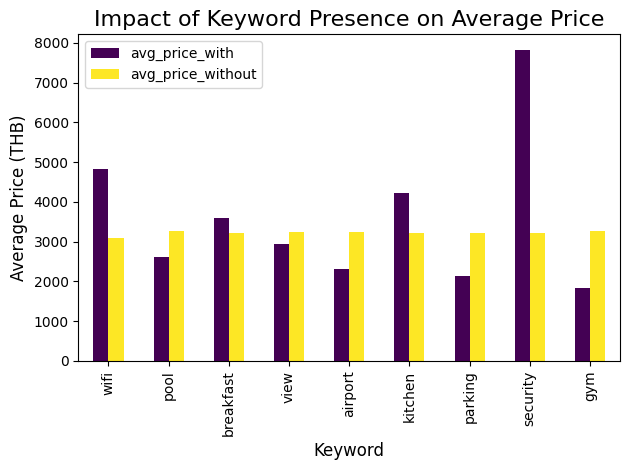

In [5]:
# Calculate the impact of each keyword on price and reviews
for keyword in keywords:
    keyword_summary.loc[keyword, "avg_price_with"] = df.loc[df[f"has_{keyword}"], "price"].mean()
    keyword_summary.loc[keyword, "avg_price_without"] = df.loc[~df[f"has_{keyword}"], "price"].mean()

# Convert columns to numeric
keyword_summary = keyword_summary.apply(pd.to_numeric)

# Plot the impact of keyword presence on average price
plt.figure(figsize=(14, 8))
keyword_summary[["avg_price_with", "avg_price_without"]].plot(kind="bar", stacked=False, colormap="viridis")
plt.title("Impact of Keyword Presence on Average Price", fontsize=16)
plt.xlabel("Keyword", fontsize=12)
plt.ylabel("Average Price (THB)", fontsize=12)
plt.tight_layout()
plt.show()

The graph shows how the presence of specific keywords in listing descriptions impacts the average price. Keywords like "breakfast," "wifi," "kitchen," and "security" are associated with higher prices, indicating that listings highlighting these features can command premium rates.

<Figure size 1400x800 with 0 Axes>

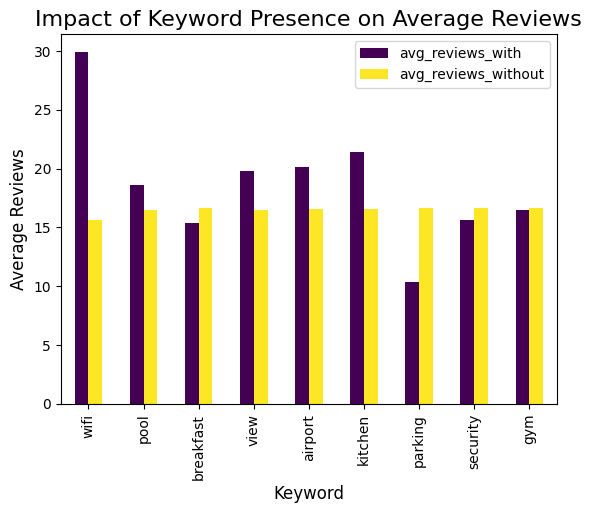

In [6]:
# Calculate the impact of each keyword on reviews
for keyword in keywords:
    keyword_summary.loc[keyword, "avg_reviews_with"] = df.loc[df[f"has_{keyword}"], "number_of_reviews"].mean()
    keyword_summary.loc[keyword, "avg_reviews_without"] = df.loc[~df[f"has_{keyword}"], "number_of_reviews"].mean()

# Convert columns to numeric
keyword_summary = keyword_summary.apply(pd.to_numeric)

# Plot the impact of keyword presence on average reviews
plt.figure(figsize=(14, 8))
keyword_summary[["avg_reviews_with", "avg_reviews_without"]].plot(kind="bar", stacked=False, colormap="viridis")
plt.title("Impact of Keyword Presence on Average Reviews", fontsize=16)
plt.xlabel("Keyword", fontsize=12)
plt.ylabel("Average Reviews", fontsize=12)
plt.show()

The graph illustrates the relationship between keyword presence and the number of reviews. Keywords such as "wifi," "kitchen," and "pool," "airport," and "view" are associated with a higher number of reviews, suggesting that these features are important to guests and can lead to more bookings.

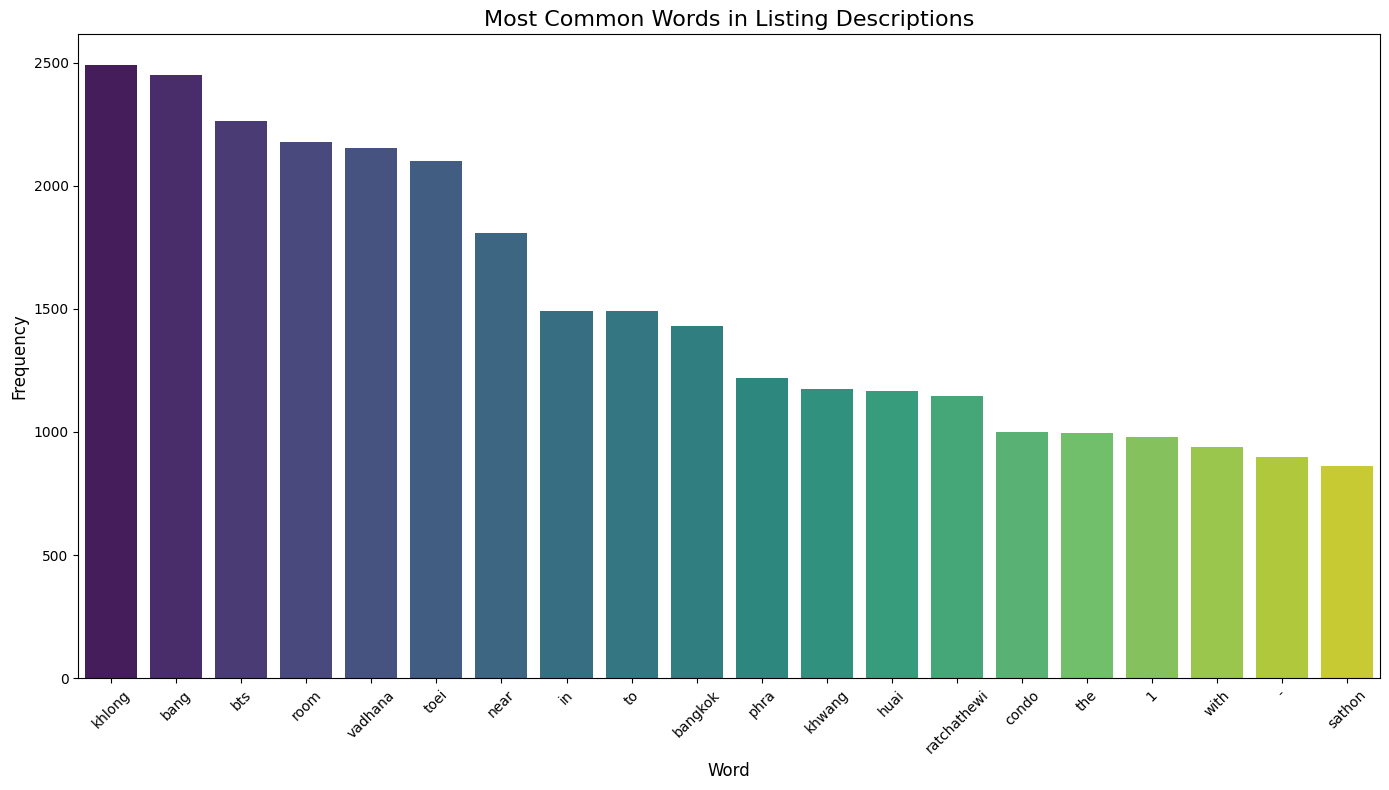

In [7]:
# Analyze the frequency of keywords in descriptions
all_words = " ".join(df["description"]).lower().split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(20)

# Plot the most common words in descriptions
plt.figure(figsize=(14, 8))
sns.barplot(x=[word for word, freq in common_words], y=[freq for word, freq in common_words], palette="viridis")
plt.title("Most Common Words in Listing Descriptions", fontsize=16)
plt.xlabel("Word", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The graph displays the most frequently used words in listing descriptions. Common terms include "room," "near," "bangkok," and "condo," indicating that location and property type are frequently emphasized.

### **4.2. English vs. Non-English Listing Analysis**

In [23]:
# Define functions to clean the text
def remove_symbols(text):
    emoji_pattern = re.compile(pattern="["
                                     u"\U0001F600-\U0001F64F"
                                     u"\U0001F300-\U0001F5FF"
                                     u"\U0001F680-\U0001F6FF"
                                     u"\U0001F700-\U0001F77F"
                                     u"\u2600-\u26FF"
                                     u"\u2700-\u27BF"
                                     u"\u25A0-\u25FF"
                                     u"\u1D10-\u1D1F"
                                     u"\u2460-\u24FF"
                                     "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r"", text)

def contains_only_english_words(input_string):
    pattern = r"^[a-zA-Z0-9\s" + re.escape(string.punctuation) + "]+$"
    return re.match(pattern, input_string) is not None

# Apply the cleaning and classification to the dataframe
df["name_without_emoji"] = df["name"].apply(remove_symbols)

# Classify listings as English or non-English
df["listing_language"] = df['name_without_emoji'].apply(contains_only_english_words)
df["listing_language"] = np.where(df["listing_language"], "English", "Non-English")

# Check the distribution of English vs. non-English listings
language_distribution = df["listing_language"].value_counts()

language_distribution = pd.DataFrame(language_distribution).reset_index()

language_distribution

,listing_language,count
0,English,13443
1,Non-English,2410


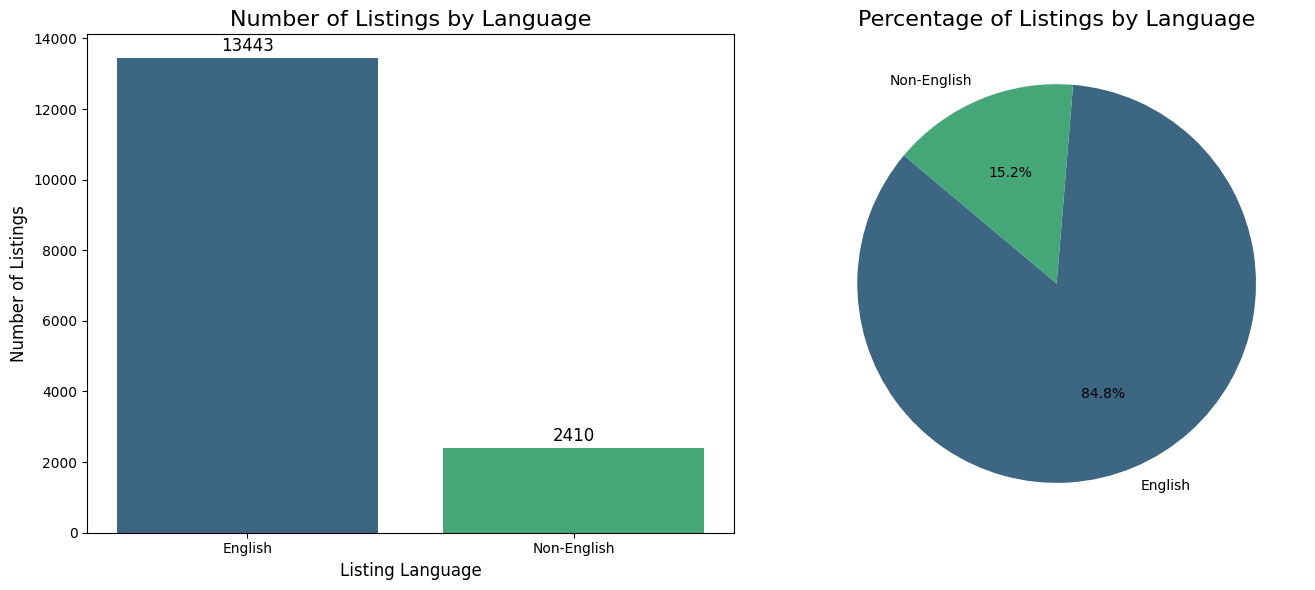

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Bar Plot: Number of Listings by Language
ax1.bar(language_distribution["listing_language"], language_distribution["count"], color=['#3c6682', '#45a778'])
ax1.set_title('Number of Listings by Language', fontsize=16)
ax1.set_xlabel('Listing Language', fontsize=12)
ax1.set_ylabel('Number of Listings', fontsize=12)
for i in range(len(language_distribution)):
    ax1.text(i, language_distribution["count"][i] + 200, str(language_distribution["count"][i]), ha='center', fontsize=12)

# Pie Chart: Percentage of Listings by Language
ax2.pie(language_distribution["count"], labels=language_distribution["listing_language"], autopct='%1.1f%%', colors=['#3c6682', '#45a778'], startangle=140)
ax2.set_title('Percentage of Listings by Language', fontsize=16)

plt.tight_layout()
plt.show()

The graph highlights that English dominates Bangkok Airbnb listings, representing 84.8% of the total, while the 15.2% non-English listings suggest an opportunity to cater to a niche market of non-English-speaking guests.

In [9]:
# Analyze the impact of listing language on price and reviews
language_impact = df.groupby("listing_language").agg(
    avg_price=("price", "mean"),
    avg_reviews=("number_of_reviews", "mean")
).reset_index()

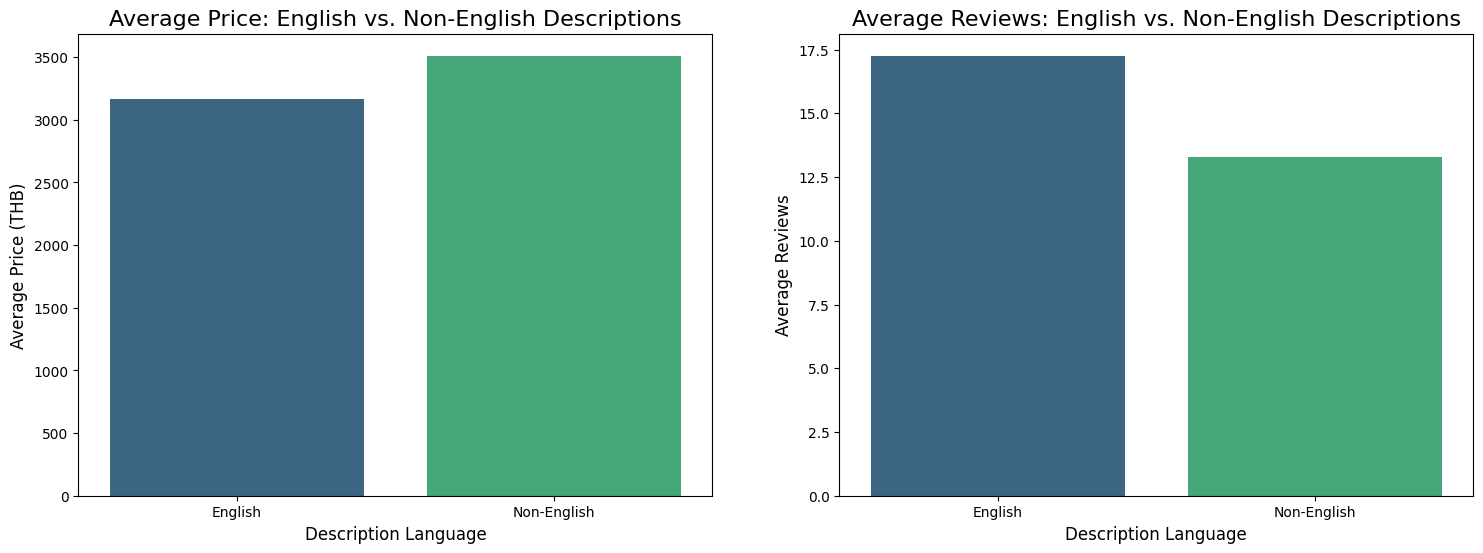

In [32]:
plt.figure(figsize=(18, 6))

# Average Price for English vs. Non-English Descriptions
plt.subplot(1,2,1)
sns.barplot(x="listing_language", y="avg_price", data=language_impact, palette="viridis")
plt.title("Average Price: English vs. Non-English Descriptions", fontsize=16)
plt.xlabel("Description Language", fontsize=12)
plt.ylabel("Average Price (THB)", fontsize=12)

# Average Reviews for English vs. Non-English Descriptions
plt.subplot(1,2,2)
sns.barplot(x="listing_language", y="avg_reviews", data=language_impact, palette="viridis")
plt.title("Average Reviews: English vs. Non-English Descriptions", fontsize=16)
plt.xlabel("Description Language", fontsize=12)
plt.ylabel("Average Reviews", fontsize=12)
plt.show()

Listings with descriptions in non-English tend to have a higher average price compared to English listings. However, listings with English descriptions generally receive more reviews on average. This suggests that English descriptions could lead to higher booking rates, potentially due to better visibility and understanding by a global audience.

#### **Strategic Implications**

The analysis of listing descriptions and keywords provides valuable insights into how different elements of a listing's text can influence pricing, guest engagement, and overall performance on Airbnb. The key implications can be summarized as follows:

**1. Impact of High-Value Keywords**:
   - **Observation**: Keywords like "breakfast," "wifi," "kitchen," and "security" are associated with higher average prices. Listings that highlight these amenities tend to command premium rates.
   - **Impact**: Hosts should ensure that if their property offers these desirable features, the keywords are prominently featured in the listing description. Emphasizing high-value amenities can increase the perceived value of the property, allowing hosts to set higher prices and attract guests willing to pay more.

**2. Importance of Essential Amenities**:
   - **Observation**: Keywords such as "wifi," "kitchen," "pool," "airport," and "view" correlate with a higher number of reviews, indicating their importance to guests. These amenities are often considered essential by travelers.
   - **Impact**: Hosts should prioritize mentioning essential amenities in their descriptions. These features enhance guest satisfaction and lead to more positive reviews, which in turn can boost a listing’s visibility and booking rate. Focusing on these essentials can help increase occupancy and encourage repeat bookings.

**3. Optimization Through Common Keywords**:
   - **Observation**: Commonly used words in descriptions, such as "room," "near," "bangkok," and "condo," emphasize property type and location. These terms are frequently utilized by successful listings to attract potential guests.
   - **Impact**: Hosts should align their descriptions with common search terms to improve visibility. Using clear and descriptive language that highlights the type of property and its location can make the listing more attractive and easier to find by potential guests. This can lead to higher engagement and booking rates.

**4. Language as a Strategic Tool**:
   - **Observation**: Listings with descriptions in English tend to have lower average prices and receive more reviews. This suggests that English descriptions appeal more broadly, particularly to international travelers.
   - **Impact**: For hosts targeting a global audience, writing descriptions in English can be a significant advantage. English descriptions improve accessibility for non-native speakers and can attract more bookings from international guests. Hosts in tourist-heavy areas or regions popular with international travelers should consider prioritizing English in their listings to maximize reach and profitability. However, there's still an opportunity to cater to a niche market of non-English-speaking guests.

#### **Strategic Recommendations**

1. **Emphasize High-Value Features**: Hosts should highlight any premium amenities such as breakfast, kitchen, or enhanced security in their descriptions to attract guests willing to pay higher prices. The strategic use of these keywords can increase the listing's perceived value and pricing power.

2. **Focus on Essential Amenities**: Ensure that essential features like Wi-Fi, kitchen facilities, and pools are clearly mentioned in the description. These amenities are critical to guest satisfaction and can lead to more bookings and positive reviews, improving the listing’s performance.

3. **Use Clear and Descriptive Language**: Optimize listing descriptions with common keywords that emphasize property type and location. This approach improves visibility in search results and makes the listing more appealing to potential guests, leading to higher engagement.

4. **Consider English Descriptions**: For hosts aiming to attract international guests, using English in the listing description is advisable. English descriptions are more likely to result in more reviews (occupancy), enhancing the listing’s overall success.

#### **Conclusion**

The strategic use of keywords and language in Airbnb listing descriptions can significantly influence pricing, guest engagement, and overall performance. By carefully crafting descriptions to highlight key amenities, using common search terms, and considering the language used, hosts can optimize their listings to attract more bookings, command higher prices, and ultimately achieve greater success on the platform.

Please refer to the next file for continued analysis.